Because of the computer problem, we could not run all the factors to build the regression model. Thus, we just choose 100 stocks to finish this project, and all the regression model are completed under 30 stocks’ data.<br>
Very very sorry about that.<br><br>

We have also done the bonus question2, please refer to another ipynb.<br>

Group member:<br>
JIANG Xinyi 1155146533<br>
ZHANG Mengqi 1155156441<br>
OU Siyun 1155151524<br>
Xu Wantong 1155151744<br>
WANG Tianyuan 1155147457<br>

# Project 2 QuantFund

In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from os import listdir

## Preparation: Calculate the forward returns for stocks and market indices

In [2]:
csv_path = "0 Data/"
stockclose = "StockClosePrice"
indexclose = "IndexClosePrice"

forward_day = 5 # this should depend on your rolling period

# calculate the forward returns
stock = pd.read_csv(csv_path + stockclose + ".csv", index_col = 0, parse_dates = True)
stockforward = stock.shift(periods = -forward_day, freq = None, axis = 0) #
# 5Dforward(t) = (close_price(t+5)-close_price(t))/close_price(t)
stockforwardreturn = (stockforward - stock) / stock
print(stockforwardreturn.head())
stockforwardreturn.to_csv(os.path.join(csv_path, '5DForward.csv')) 

# In the simulation, 
# you should also calculate indices returns, 
# and hedge your portfolio with any one of them.
index = pd.read_csv(csv_path + indexclose + ".csv", index_col = 0, parse_dates = True)
indexforward = index.shift(periods = -forward_day, freq = None, axis = 0)
indexforwardreturn = (indexforward - index) / index
print(indexforwardreturn.head())
indexforwardreturn.to_csv(os.path.join(csv_path, 'mkt_5DForward.csv')) 

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2007-01-04   0.047482   0.061368   0.088638   0.186231   0.065688   0.122858   
2007-01-05   0.188363   0.084177   0.094316   0.107551  -0.016348   0.037043   
2007-01-08   0.219149   0.158273   0.103618   0.111985   0.006898   0.031495   
2007-01-09   0.233333   0.230769   0.096691   0.135329   0.075422   0.031128   
2007-01-10   0.208806   0.006994   0.083142   0.096759  -0.043272   0.007674   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  603987.SH  \
date                                                    ...              
2007-01-04   0.250000   0.125307        0.0   0.128390  ...        NaN   
2007-01-05   0.122891   0.073622        0.0   0.079454  ...        NaN   
2007-01-08   0.140277   0.086213        0.0   0.092567  ...        NaN   
2007-01-09   0.130120   0.044423        0.0   0.123708  ...        Na

## Read the factors

In [3]:
#Read all factor files
#You can select a sample of factors to shorten the running time

factor_folder = "0 Data/0 Selected_factors/"
factor_list = set(os.listdir(factor_folder)) - set(['.DS_Store'])#os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
factor_list = list(factor_list)

# Remeber to Z-score the factor values to remove the scale differences
dfs = []
i = 0
for factor in factor_list:
    dfs.append(factor)
    df = pd.read_csv(factor_folder + factor, index_col = 0, parse_dates = True)
    df = df.iloc[:,0:30]
    dfs[i] = (df - df.mean()) / df.std() 
    i = i + 1  


print(dfs[0].head())

            000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  000007.SZ  \
date                                                                           
2008-01-02        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-07        NaN        NaN        NaN        NaN        NaN        NaN   
2008-01-08        NaN        NaN        NaN        NaN        NaN        NaN   

            000008.SZ  000009.SZ  000010.SZ  000011.SZ  ...  000024.SZ  \
date                                                    ...              
2008-01-02        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-03        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-04        NaN        NaN        NaN        NaN  ...        NaN   
2008-01-07        NaN        NaN        NaN        NaN  ...        Na

## Re-organize the data

In [4]:
#list all the factors
factors = ['return']
for i in range(len(factor_list)):
    factors.append(factor_list[i][:-4])

#match the data of return and factor
return_cut = stockforwardreturn[dfs[0].columns][dfs[0].index[0]:dfs[0].index[-1]]

#Construct each stock's dataset
data_trans=[]
for i in range(return_cut.shape[1]):
    temp = return_cut.iloc[:,i:i+1]
    data_trans.append(temp)
    for j in range(len(dfs)):
        temp = pd.concat([temp,dfs[j].iloc[:,i:i+1]],axis=1)
    temp.set_axis(factors, axis='columns', inplace=True)
    temp['index']=range(1,len(temp)+1)
    temp['index']=temp['index'].apply(lambda x:str(i+1)+','+str(x))
    temp.set_index(['index'],inplace=True)
    data_trans[i] = temp

#concat all the stock's data together
temp=data_trans[0].copy()

for i in range(1,len(data_trans)):
    temp = pd.concat([temp,data_trans[i]],axis=0)
    
#save_result_path =  '0 Data/'
#temp.to_csv(os.path.join(save_result_path, 'temp.csv'))

#temp=pd.read_csv("0 Data/temp.csv", index_col=0)

## Deal with the missing value

In [5]:
data1 = temp.dropna(subset=['return'])

data1.isnull().sum()

# to balance the number of factors and the size of dataset, 
# drop the factors with missing value more that 10000000
# then drop the missing values for factors left
core_factors = data1.isnull().sum()[data1.isnull().sum()<1000000].index
data = data1[core_factors].dropna()
data

,return,RealizedVolatility,DAVOL20,ROAEBITTTM,LongTermDebtToAsset,TVMA6,GainLossVarianceRatio20,SalesCostRatio,InformationRatio60,REVS750,MoneyFlow20,PEHist60,ROE5
index,,,,,,,,,,,,,
"2,247",0.016418,-0.215174,0.204384,1.572421,0.535918,-0.626250,-0.838437,-1.089222,0.573494,-0.661884,-0.269442,0.130386,2.803765
"2,248",-0.047825,0.003336,0.073483,1.572421,0.535918,-0.581675,-0.841472,-1.089222,0.615432,-0.624074,-0.311837,0.323430,2.803765
"2,249",0.004374,0.015309,-0.113519,1.572421,0.535918,-0.582662,-0.845172,-1.089222,0.443936,-0.631781,-0.372593,0.271810,2.803765
"2,250",-0.007246,0.114087,-0.207019,1.572421,0.535918,-0.594178,-0.826215,-1.089222,0.370544,-0.624074,-0.398948,0.305752,2.803765
"2,251",0.004355,-0.185241,-0.281820,1.572421,0.535918,-0.611911,-0.816737,-1.089222,0.058256,-0.626121,-0.423087,0.290903,2.803765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"30,2304",0.099884,-0.209606,1.420219,0.319078,0.979491,0.548710,-0.770296,0.767976,-2.043726,-1.515326,-0.516000,-0.011252,-2.562305
"30,2305",0.088260,-0.235881,1.591345,0.319078,0.979491,0.651307,-0.869189,0.767976,-1.973769,-1.488417,-0.477538,-0.010598,-2.562305
"30,2306",0.080463,-0.239166,1.762471,0.319078,0.979491,0.729758,-0.874004,0.767976,-2.022878,-1.473487,-0.446763,-0.010554,-2.562305


## Training Factors: Linear Regression

In [6]:
from sklearn import linear_model

#data = temp.dropna()

X = data.drop(['return'], axis=1)
Y = data['return']

model = linear_model.LinearRegression()
model.fit(X, Y)

yhat=data[['return']].copy()
yhat['return']=model.predict(X)

temp1=temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/1 New_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Linear_Reg_factor.csv'))

In [7]:
print(model.score(X,Y))

0.008659357413454138


## Backtesting Simulation

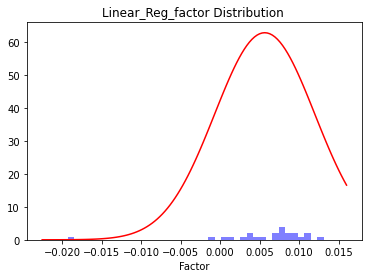

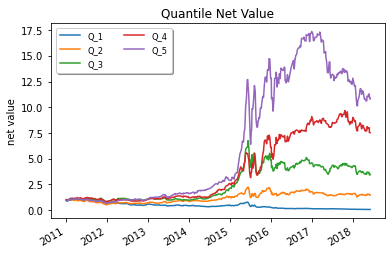

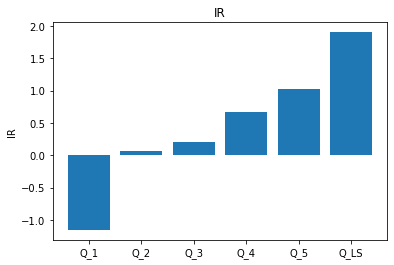

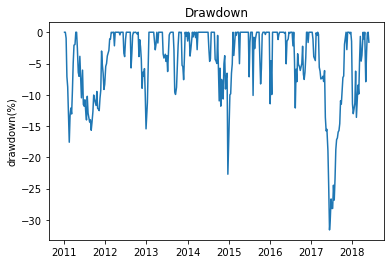

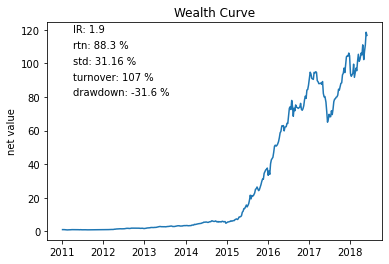

In [8]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/1 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Linear_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## Training Factors: Lasso Regression

In order to avoid the overfitting of the linear regression, we also use regularised regression such as ridge regression and lasso regression to fit the model by applying additional constraints to the weight vector. In these two regularised regression, we need to find the optimized alpha, a scalar on the regularization amount. Thus, we apply cross validation (RidgeCV and LassoCV) to find the optimized alpha.


In [9]:
from sklearn.linear_model import Lasso
''' To get the optimized alpha through the cross validation'''
from sklearn.linear_model import LassoCV

Lambdas = np.logspace(-6, 2, 50)
lassocv = LassoCV(alphas=Lambdas, normalize=True, cv=10)
lassocv.fit(X, Y)
alpha2 = lassocv.alpha_
print('The optimized alpha through LassoCV：' + str(alpha2))

'''lasso Regression'''
lasso = Lasso(alpha2) 
lasso.fit(X, Y)

yhat=data[['return']].copy()
yhat['return']=lasso.predict(X)

temp1=temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/1 New_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Lasso_Reg_factor.csv'))

The optimized alpha through LassoCV：3.0888435964774785e-06


In [10]:
print(lasso.score(X,Y))

0.008659333526028545


## Backtesting Simulation

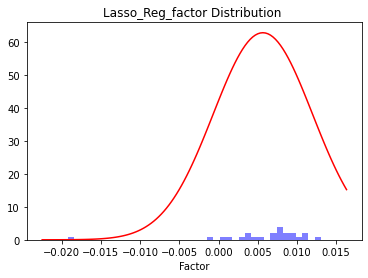

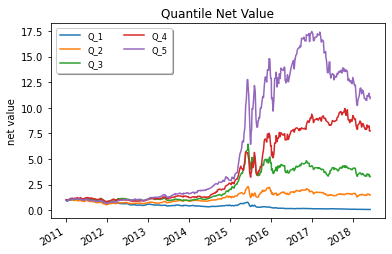

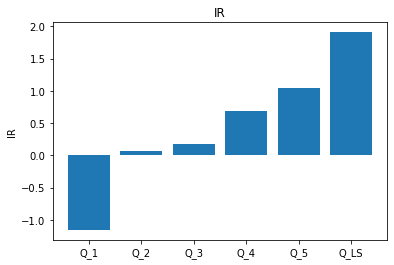

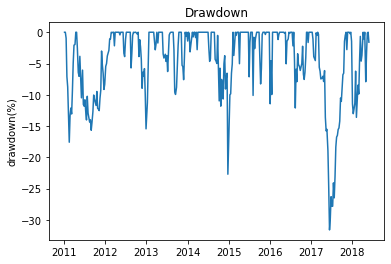

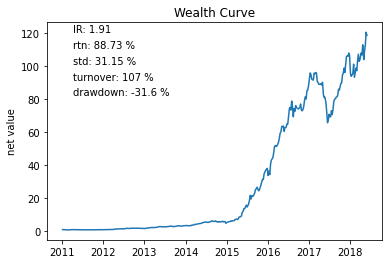

In [11]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/1 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Lasso_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## Training Factors: Ridge Regression

In [12]:
from sklearn.linear_model import Ridge
 
''' To get the optimize alpha through cross validation'''
from sklearn.linear_model import RidgeCV

Lambdas = np.logspace(-5, 2, 50)
ridgecv = RidgeCV(alphas=Lambdas, normalize=True, scoring='neg_mean_squared_error', cv=10)
ridgecv.fit(X, Y)

alpha1 = ridgecv.alpha_
print('The optimize alpha through RidgeCV：' + str(alpha1))

'''Ridge Regression'''
ridge = Ridge(alpha1, normalize=True)
ridge.fit(X, Y)

yhat=data[['return']].copy()
yhat['return']=ridge.predict(X)

temp1=temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/1 New_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'Ridge_Reg_factor.csv'))

The optimize alpha through RidgeCV：0.3727593720314938


In [13]:
print(ridge.score(X,Y))

0.008336393016044497


## Backtesting Simulation

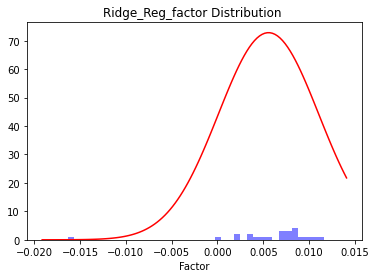

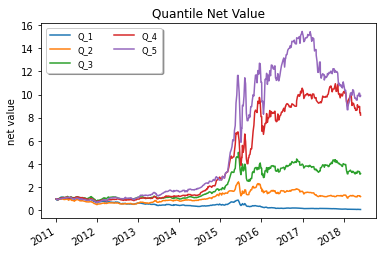

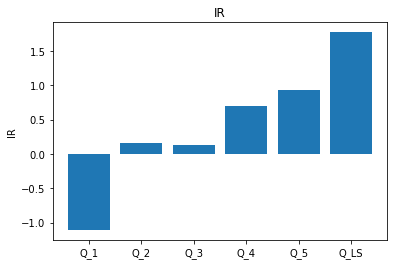

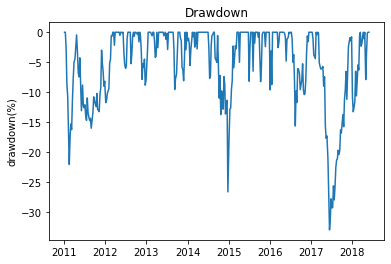

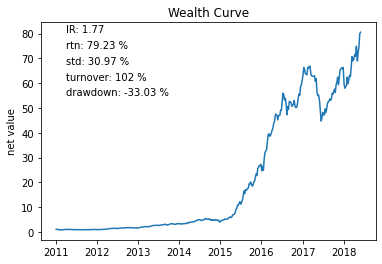

In [14]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/1 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "Ridge_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## Training Factors: Random Forest Regressor

We also use random forest regressor to build a regression model. In this model, we need to apply the cross validation to choose the best estimator for this random forest. <br>From the cross-validation score graph, we find the optimized estimators for this random forest is 75.<br>
Use 75 as the n-estimator to fit the model and to predict the return, which has be collected in a csv file for the back testing.

In [15]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [21]:
from sklearn.model_selection import train_test_split
features = data.drop(['return'], axis=1).iloc[-1000:,]
labels = data['return'].iloc[-1000:,]
train_features,test_features,train_labels,test_labels = train_test_split(features,labels,test_size=0.25,random_state=3)



In [ ]:
# choose the beat number of estimator
n_range = range(1,101)
score = []
for n in n_range:
    rfr = RandomForestRegressor(n_estimators= n, n_jobs = 1, random_state=42)
    rf_score = cross_val_score(rfr, train_features, train_labels, cv = 10, scoring = 'r2')
    score.append(rf_score.mean())

#Choose the best estimators through the graph
plt.plot(n_range,score)
plt.xlabel('N-Estimators')
plt.ylabel('Accuracy')
plt.show()

#the optimized number of estimators
max1 = np.array(score).max()
index = score.index(max1)
print(max1, index)

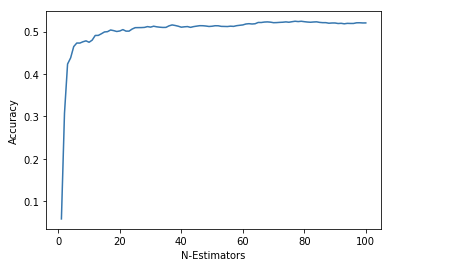

In [22]:
# the best random forest model
# Instantiate model 
rf = RandomForestRegressor(n_estimators= 76, random_state=42)
 
# Train the model on training data
rf.fit(X, Y)

print(rf.score(X,Y))

0.9363738464793637


In [23]:
y_rf=data[['return']].copy()
y_rf['return']=rf.predict(X)

temp1=temp[['return']].join(y_rf,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/1 New_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'RandomForest_Reg_factor.csv'))

## Backtesting Simulation

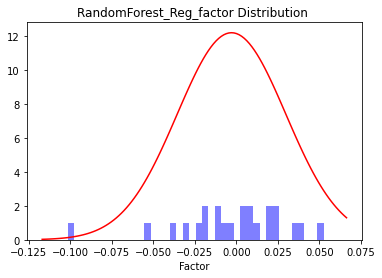

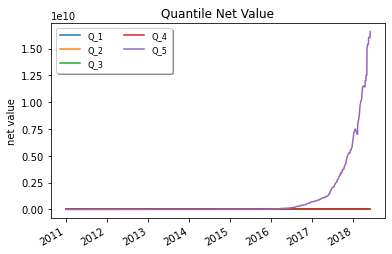

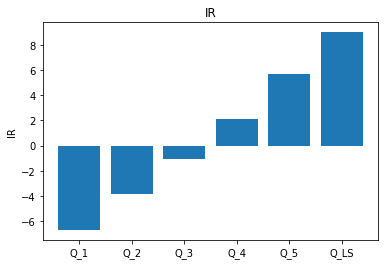

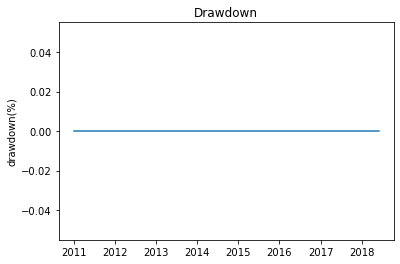

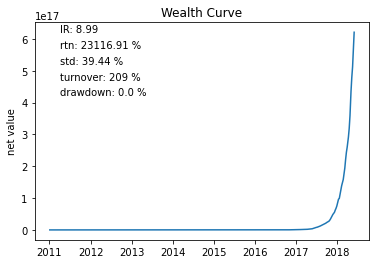

In [24]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/1 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "RandomForest_Reg_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## Training Factors: SVR

According to the scikit learn, the fit time complexity of SVR is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples. For large datasets consider using LinearSVR or SGDRegressor instead. Thus we use LinearSVR to replace the SVR and fit the model.<br>
Similar to SVR with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

In [25]:
X = data.drop(['return'], axis=1)
Y = data['return']

from sklearn.svm import LinearSVR

svr = LinearSVR(random_state=0, tol=1e-5)
svr.fit(X, Y)

yhat=data[['return']].copy()
yhat['return']=svr.predict(X)

temp1=temp[['return']].join(yhat,lsuffix=1)[['return']]

for i in range(return_cut.shape[1]):
    if i == 0:
        factors_reg = temp1[0:return_cut.shape[0]]
        factors_reg.insert(0,'date',return_cut.index)
        factors_reg.set_index(['date'],inplace=True)
    else:
        temp2 = temp1[i*return_cut.shape[0]:(i+1)*return_cut.shape[0]]
        temp2.insert(0,'date',return_cut.index)
        temp2.set_index(['date'],inplace=True)
        
        factors_reg = pd.concat([factors_reg,temp2],axis=1)

factors_reg.set_axis(return_cut.columns, axis='columns', inplace=True)

save_result_path =  '0 Data/1 New_factors/'
factors_reg.to_csv(os.path.join(save_result_path, 'SVR_factor.csv'))

/Users/anda-jiang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## Backtesting Simulation

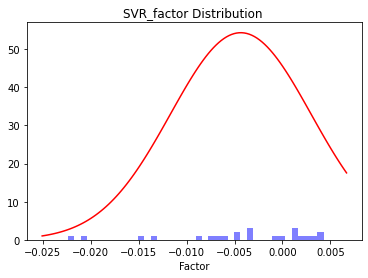

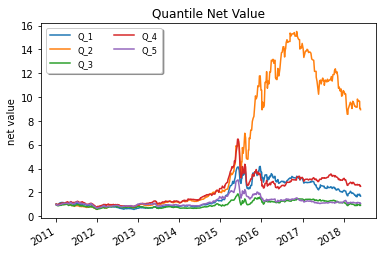

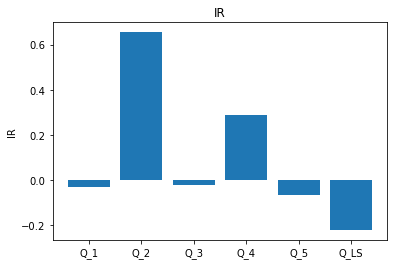

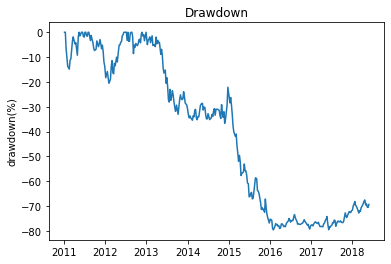

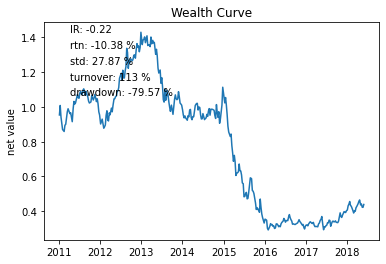

In [26]:
# helper.py has all formulas and plotting functions
%run -i "helper.py"

# backtestlite.py has XXX
%run -i "backtestlite.py"

#set the working directory and some initial parameters. 

working_directory = '0 Data/'
#Directory to import the factor you built
factor_path_all = '0 Data/1 New_factors/'

# Define the factor direction, (Descending or Ascending).
# The direction could be observed by the correlation between the factor your built and the stock returns. 
# "Descending" if higher factor score, lower return
# "Ascending" if higher factor score, higher return
# direction = "Descending"
direction = "Ascending"
###############################################################

# Parameters of backtest.
start = '20110101' # Time horizon, can be vacation, progrmme will extract the maximum subset.
end = '20180601'
quantile = 5
cycle = 5 # Adjustment Cycle (trading frequency), delay for holidays. 
win = 48 # 48 weeks in a year
year = 2011 # Beginning year of result display (graphs).

#Import stock 5days forward return.
fwdrtn = pd.read_csv(os.path.join(working_directory, "5DForward.csv"), index_col = 0, parse_dates = True).loc[start:end][::cycle]
#Import market 5days forward return.
mkt_index = pd.read_csv(os.path.join(working_directory, "mkt_5DForward.csv"), index_col = 0, parse_dates = True).loc[str(start):str(end),"SH000905"][::cycle]

#You might want to set trading status (whether it is tradable) when you work on bonus question
status = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)
statuslimit = pd.DataFrame(1, index = fwdrtn.index, columns = fwdrtn.columns)

# Revise the factor name (name of .csv file)
factor =  "SVR_factor"

Type = "LS" # this stand for long-short strategy. 
# Don't change this unless you are confident with the codes in backtestlite.py

def singlefactor(factor,factor_path_all,Type,direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit):
    factor_path = os.path.join(factor_path_all, factor + '.csv')

    Type1 = "LS"
    B = Backtestlite(factor_path, direction, fwdrtn, mkt_index, factor_path_all, cycle, start, end, quantile, statuslimit)
    B.run(Type1)

    # Drawing
    pic = DrawPicture(factor,direction, B.data,  B.fwdrtn, B.data.index , mkt_index,  B.rtn_data, B.coverage, B.turnover, factor_path_all, Type1)    
    pic.main(win,year,B.rtn_data.columns)
    
# Calculate performances and do the plot
singlefactor(factor,factor_path_all,Type, direction,fwdrtn,mkt_index,cycle, start, end, quantile,win,year, statuslimit)

## Cross Validation

In [27]:
from sklearn.model_selection import cross_val_score

#对 Randomforest Regressor进行评分
rfr = RandomForestRegressor(n_estimators= 76, random_state=42)
rf_score = cross_val_score(rfr, X, Y, cv = 10)

# 对linear regression进行评分
linear = linear_model.LinearRegression()
linear_score = cross_val_score(linear, X, Y, cv = 10)

#对lasso regression进行评分
lasso = Lasso(alpha2)
lasso_score = cross_val_score(lasso, X, Y, cv = 10)

#对ridge regression进行评分
ridge = Ridge(alpha1)
ridge_score = cross_val_score(ridge, X, Y, cv = 10)

#对SVR进行评分
svr = LinearSVR(random_state=0, tol=1e-5)
svr_score = cross_val_score(svr, X, Y, cv = 10)

# Paired T Test
from scipy import stats

/Users/anda-jiang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/anda-jiang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/anda-jiang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/anda-jiang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/anda-jiang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976

In [28]:
rf_score1 = list(zip(rf_score))
linear_score1 = list(zip(linear_score))
lasso_score1 = list(zip(lasso_score))
ridge_score1 = list(zip(ridge_score))
svr_score1 = list(zip(svr_score))
method = ['random_forest','linear', 'lasso', 'ridge', 'svr']

summary = np.concatenate((rf_score1,linear_score1, lasso_score1, ridge_score1, svr_score1 ), axis = 1)
summary = pd.DataFrame(summary,columns= method)

summary.loc['mean'] = summary.apply(lambda x: x.mean())
summary.loc['std'] = summary.apply(lambda x: x.std())

summary


,random_forest,linear,lasso,ridge,svr
0,-0.076702,0.007669,0.007665,0.007669,-0.018460
1,-0.080779,0.005435,0.005438,0.005435,-0.011635
2,-0.087721,0.014507,0.014511,0.014507,-0.003177
3,-0.072850,0.011654,0.011654,0.011654,0.001162
4,-0.090211,0.003387,0.003398,0.003387,-0.022731
5,-0.047726,0.012949,0.012962,0.012949,-0.001977
6,-0.142470,-0.006606,-0.006588,-0.006606,-0.053779
7,-0.078499,0.000016,0.000038,0.000016,-0.016559
8,-0.117757,0.001112,0.001140,0.001112,-0.067341
9,-0.034294,0.007169,0.007180,0.007169,-0.010394


By comparing the mean and std, we find that the linear and ridge have the highest score, so we guess the two models fit the best, to verify our thought, we have to look at backtest.

In [29]:
from scipy import stats

rf_ln = stats.ttest_ind(rf_score,linear_score)
rf_la = stats.ttest_ind(rf_score,lasso_score)
rf_ri = stats.ttest_ind(rf_score,ridge_score)
rf_svr = stats.ttest_ind(rf_score,svr_score)
ln_la = stats.ttest_ind(linear_score,lasso_score)
ln_ri = stats.ttest_ind(linear_score,ridge_score)
ln_svr = stats.ttest_ind(linear_score,svr_score)
la_ri = stats.ttest_ind(lasso_score,ridge_score)
la_svr = stats.ttest_ind(lasso_score,svr_score)
ri_svr = stats.ttest_ind(ridge_score,svr_score)

name = [rf_ln,rf_la,rf_ri,rf_svr,ln_la,ln_ri,ln_svr,la_ri,la_svr,ri_svr]
mean = []
for i in name:
    mean.append(i[0])
    
p_value=[]
for i in name:
    p_value.append(i[1])

name2 = ['rf_ln','rf_la','rf_ri','rf_svr','ln_la','ln_ri','ln_svr','la_ri','la_svr','ri_svr']
df = pd.DataFrame({'mean': mean,'p_value':p_value},index= name2)

df


,mean,p_value
rf_ln,-8.870339,5.463468e-08
rf_la,-8.871753,5.450578e-08
rf_ri,-8.870343,5.463423e-08
rf_svr,-5.149039,6.731920e-05
ln_la,-0.003599,9.971682e-01
ln_ri,-0.000014,9.999888e-01
ln_svr,3.517168,2.461082e-03
la_ri,0.003584,9.971794e-01
la_svr,3.518835,2.451990e-03
ri_svr,3.517174,2.461049e-03


Here, by looking at p value, we find that the models are totally different.

## some conclusion about backtest

Best model:<br>
According to the comparison diagram above, it is quite obvious that random forest is the best model which has the highest information ratio and return. Besides, although the standard deviation is high, the graphs actually show a smooth increase in return, which means that the portfolio generated by random forest has very small variance in return and increases steadily over time.  All these performances show that random forest is the best model.With its relatively optimal prediction result, we can accurately change our portfolio composition, a strategy indicated by a higher turnover ratio. <br>

Moderate model:
Linear, Lasso, Ridge Regression generate similar results, which is quite reasonable, since the optimal regularization factors  of lasso and ridge generated by cross validation algorithm( RidgeCV, LassoCV) are small, and  all of these models got very close R^2 scores.
Their backtest graphs are also of high similarity.<br>

Inferior model:
SVR model here didn’t perform well. Its information ratio and return are apparently lower than those of other models. Additionally, all the graphs show dramatic fluctuation, telling that the portfolio generated by SVR has large variance in return and thus the model is very unstable.

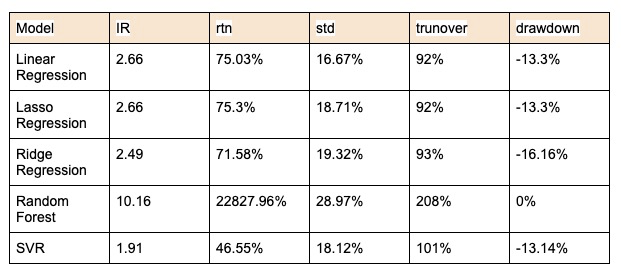